# 5A. ADI forward modeling of point sources

> Authors: *Valentin Christiaens* and *Carlos Alberto Gomez Gonzalez*  
> Suitable for VIP *v1.0.3* onwards  
> Last update: *2024/03/25*

**Table of contents**

* [5.1. Loading ADI data](#5.1.-Loading-ADI-data)
* [5.2. Generating and injecting synthetic planets](#5.2.-Generating-and-injecting-synthetic-planets)
* [5.3. Flux and position estimation with NEGFC](#5.3.-Flux-and-position-estimation-with-NEGFC)
    - [5.3.1. Nelder-Mead based optimization](#5.3.1.-Nelder-Mead-based-optimization)
    - [5.3.2. Planet subtraction](#5.3.2.-Planet-subtraction)
    - [5.3.3. NEGFC technique coupled with MCMC](#5.3.3.-NEGFC-technique-coupled-with-MCMC)
        - [5.3.3.1. Running the MCMC sampler](#5.3.3.1.-Running-the-MCMC-sampler)
        - [5.3.3.2. Visualizing the MCMC chain: corner plots and walk plots](#5.3.3.2.-Visualizing-the-MCMC-chain:-corner-plots-and-walk-plots)
        - [5.3.3.3. Highly probable values and confidence intervals](#5.3.3.3.-Highly-probable-values-and-confidence-intervals)
    - [5.3.4. NEGFC technique coupled with nested sampling](#5.3.4.-NEGFC-technique-coupled-with-nested-sampling)
    - [5.3.5. Residual speckle uncertainty](#5.3.5.-Residual-speckle-uncertainty)
    - [5.3.6. Final uncertainties](#5.3.6.-Final-uncertainties)

This tutorial shows:

- how to generate and inject fake companions in a cube;
- how to estimate the astrometry and photometry of a directly imaged companion, and associated uncertainties.

---
**NOTE**

A number of routines in the `fm` subpackage have been implemented for compatibility with multiprocessing, in order to optimally harness the power of machines equipped with multiple CPUs. Any function where the `nproc` parameter is available in its call (or which internally calls a `psfsub` function) can be run in multi-processing, with the value of `nproc` setting the requested number of CPUs to use. Instead of an integer, one can set `nproc=None` to use half of all available CPUs. For optimal results in multiprocessing, set the following environment parameters **BEFORE** launching your Jupyter notebook:
    
    export MKL_NUM_THREADS=1
    export NUMEXPR_NUM_THREADS=1
    export OMP_NUM_THREADS=1

In the case of PCA, singular value decomposition can also be done on **GPU** by setting `svd_mode` to an appropriate value (see [Sec. 3.5.1.](https://vip.readthedocs.io/en/v1.4.0/tutorials/03_psfsub.html#3.5.1.-Full-frame-PCA) and docstrings of ``vip_hci.psfsub.pca`` for details).

---

-----------

Let's first import a couple of external packages needed in this tutorial:

In [1]:
%matplotlib inline
from hciplot import plot_frames, plot_cubes
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import numpy as np
from packaging import version

In the following box we check that your version of VIP passes the requirements to run this notebook:

In [2]:
import vip_hci as vip
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) <= version.parse("1.0.3"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be strictly above 1.0.3 to run this notebook."
    raise ValueError(msg)

VIP version:  1.6.0


## 5.1. Loading ADI data

In the 'dataset' folder of the `VIP_extras` repository you can find a toy ADI (Angular Differential Imaging) cube and a NACO point spread function (PSF) to demonstrate the capabilities of ``VIP``. This is an L'-band VLT/NACO  dataset of beta Pictoris published in [Absil et al. (2013)](https://ui.adsabs.harvard.edu/abs/2013A%26A...559L..12A/abstract) obtained using the Annular Groove Phase Mask (AGPM) Vortex coronagraph. The sequence has been heavily sub-sampled temporarily to make it smaller. The frames were also cropped to the central 101x101 area. In case you want to plug-in your cube just change the path of the following cells.

More info on this dataset, and on opening and visualizing fits files with VIP in general, is available in Tutorial `1. Quick start`.

Let's load the data:

In [3]:
from vip_hci.fits import open_fits

psfnaco = '../datasets/naco_betapic_psf.fits'
cubename = '../datasets/naco_betapic_cube_cen.fits'
angname = '../datasets/naco_betapic_derot_angles.fits'

cube = open_fits(cubename)
psf = open_fits(psfnaco)
angs = open_fits(angname)

FITS HDU-0 data successfully loaded. Data shape: (61, 101, 101)
FITS HDU-0 data successfully loaded. Data shape: (39, 39)
FITS HDU-0 data successfully loaded. Data shape: (61,)


Let's fit the PSF with a 2D Gaussian to infer the FWHM, the flux in a 1-FWHM size aperture, and get a flux-normalized PSF:

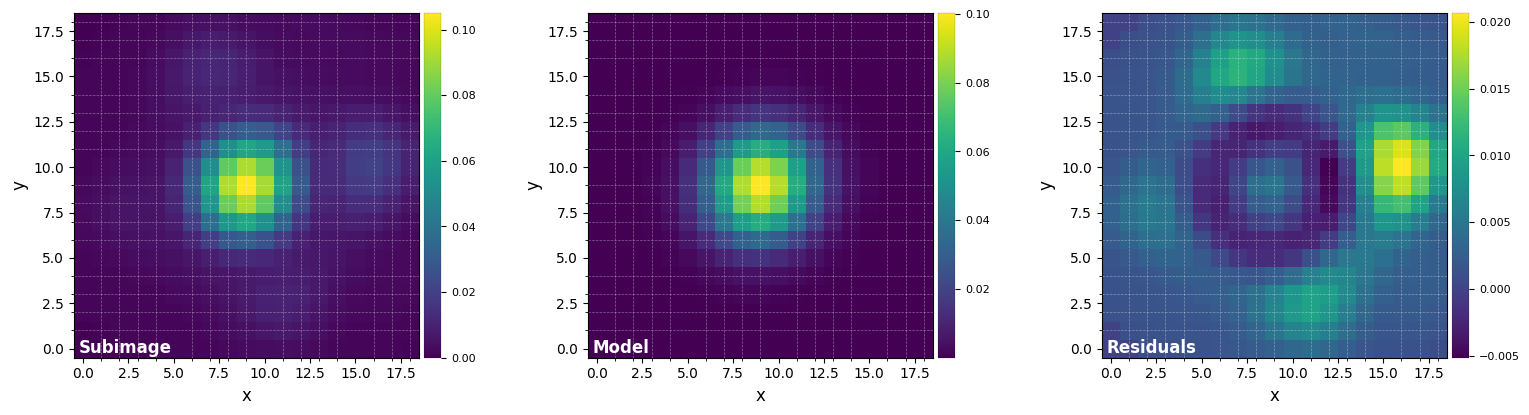

FWHM_y = 4.926059872957138
FWHM_x = 4.675778895005929 

centroid y = 9.010992107833063
centroid x = 9.01917912265807
centroid y subim = 9.010992107833063
centroid x subim = 9.01917912265807 

amplitude = 0.10032285220380603
theta = -38.446187060503874

Mean FWHM: 4.801
Flux in 1xFWHM aperture: 1.307


In [4]:
%matplotlib inline
from vip_hci.fm import normalize_psf
psfn, flux, fwhm_naco = normalize_psf(psf, size=19, debug=True, full_output=True)

In [5]:
print(fwhm_naco)

4.800919383981533


Let's visualize the flux-normalized PSF:

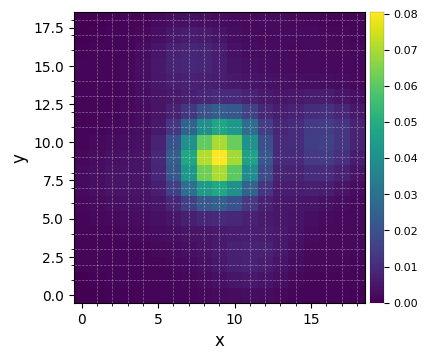

In [6]:
plot_frames(psfn, grid=True, size_factor=4)

Let's finally define the pixel scale for NACO (L' band), which we get from a dictionary stored in the `config` subpackage:

In [7]:
from vip_hci.config import VLT_NACO
pxscale_naco = VLT_NACO['plsc']
print(pxscale_naco, "arcsec/px")

0.02719 arcsec/px


## 5.2. Generating and injecting synthetic planets

We first select an image library `imlib` for image operations (shifts, rotations) and associated `interpolation` order. 'vip-fft' is more accurate, but 'skimage' is faster, and 'opencv' even faster - see `Tutorial 7` for more details.

In [8]:
imlib_rot = 'skimage'      # If you have opencv installed, feel free to set this parameter to" 'opencv'
interpolation= 'biquintic'   # If you have opencv installed, feel free to set this parameter to 'lanczos4'

The `cube_inject_companions` function in the `fm` module (VIP versions >= 1.1.0) makes the injection of fake companions at arbitrary fluxes and locations very easy. The normalized non-coronagraphic PSF should be provided for the injection. If the user does not have access to an observed PSF, the `create_synth_psf` from the `var` module can be used to create synthetic ones (based on 2D Gaussian, Moffat or Airy models).

Some procedures, e.g. the negative fake companion technique and the contrast curve generation, heavily rely on the injection of fake companions. The coordinates for the injection should be provided in the **derotated** image, while the actual injection occurs in the images of the input cube, i.e. in the *rotated* field.

In [9]:
rad_fc = 30.5
theta_fc = 240
flux_fc = 400.

gt = [rad_fc, theta_fc, flux_fc]

---
**NOTE**

The convention in VIP is to measure angles from positive x axis (i.e. as trigonometric angles), as in most other Python packages. This implies adding 90º to position angles measured following the common astronomic convention (East from North).

---

In [10]:
from vip_hci.fm import cube_inject_companions
cubefc = cube_inject_companions(cube, psf_template=psfn, angle_list=angs, flevel=flux_fc, plsc=pxscale_naco, 
                                rad_dists=[rad_fc], theta=theta_fc, n_branches=1, 
                                imlib=imlib_rot, interpolation=interpolation)


Let's set the corresponding cartesian coordinates:

In [11]:
from vip_hci.var import frame_center

cy, cx = frame_center(cube[0])
x_fc = cx + rad_fc*np.cos(np.deg2rad(theta_fc))
y_fc = cy + rad_fc*np.sin(np.deg2rad(theta_fc))

xy_test = (x_fc, y_fc)
print('({:.1f}, {:.1f})'.format(xy_test[0],xy_test[1]))

(34.7, 23.6)


Let's double-check the fake companion was injected at the right location, by post-processing the cube and checking the final image. Let's use PCA, and infer the optimal $n_{\rm pc}$ while we are at it - this will be useful for the next section.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-26 01:07:58
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.013050
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Number of steps 41
Optimal number of PCs = 7, for S/N=11.105
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 34.7, 23.6
Flux in a centered 1xFWHM circular aperture = 146.645
Central pixel S/N = 13.443
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 11.105
Max S/N (shifting the aperture center) = 15.556
stddev S/N (shifting the aperture center) = 2.665



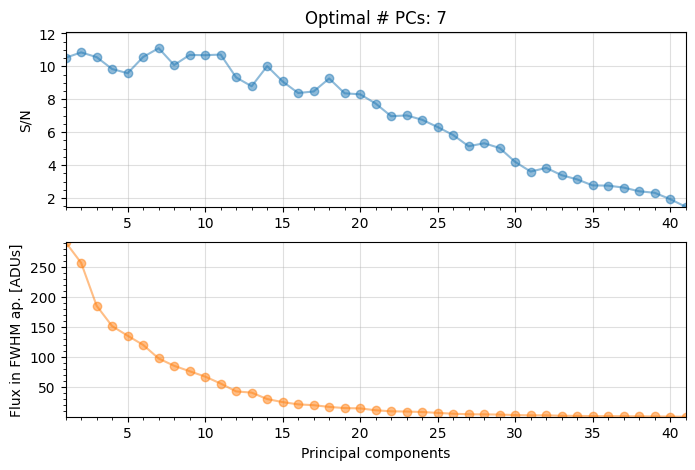

In [12]:
from vip_hci.psfsub import pca_grid
res_ann_opt = pca_grid(cubefc, angs, fwhm=fwhm_naco, range_pcs=(1,41,1), source_xy=xy_test, mode='annular',
                       annulus_width=4*fwhm_naco, imlib=imlib_rot, interpolation=interpolation, 
                       full_output=True, plot=True)

The grid search looking for the optimal number of principal components (npc) found that 10 principal components maximizes the S/N ratio of the injected fake companion. 

In [13]:
_, final_ann_opt, _, opt_npc_ann = res_ann_opt

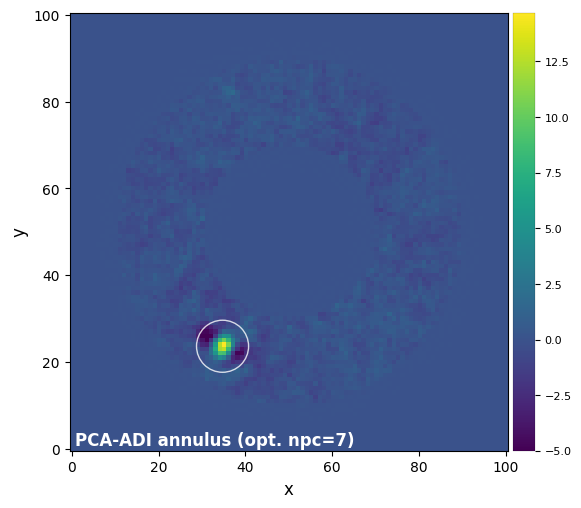

In [14]:
plot_frames(final_ann_opt, label='PCA-ADI annulus (opt. npc={:.0f})'.format(opt_npc_ann),
            dpi=100, vmin=-5, colorbar=True, circle=xy_test)

We can see that the fake companion was indeed injected at the requested location.

## 5.3. Flux and position estimation with NEGFC

When a companion candidate is detected, the next step is to characterize it, i.e. infer its exact position (astrometry) and flux (photometry). 

<font color=orange> **Question 5.1**: Why would a simple 2D Gaussian fit (as performed e.g. for the stellar PSF in Section 5.1) be inappropriate to extract the astrometry and photometry of a candidate companion? </font>

`VIP` implements the Negative fake companion (NEGFC) technique for robust extraction of the position and flux of detected point-like sources. The technique can be summarized as follow (see full description in [Wertz et al. 2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...598A..83W/abstract)):

1) Estimate the position and flux of the planet, from either the visual inspection of reduced images or a previous estimator (see ABC below).

2) Scale (in flux) and shift the normalized off-axis PSF to remove the estimate from the input data cube.

3) Process the cube with PCA in a single annulus encompassing the point source.

4) Measure residuals in an aperture centered on the approximate location of the companion candidate.

5) Iterate on the position and flux of the injected negative PSF (steps 2-4), until the absolute residuals in the aperture are minimized (i.e. the injected negative companion flux and the position match exactly that of the true companion).

Iterations between steps 2-4 can be performed in one of 3 ways - sorted in increasing computation time and accuracy: 

A) a grid search on the flux only, provided a fixed estimate of the position (implemented in the `firstguess` function);

B) a Nelder-Mead simplex algorithm (`firstguess` function with the `simplex=True` option);

C) an MCMC sampler, which has the advantage to also yield uncertainties on each of the parameters of the point source (`mcmc_negfc_sampling` function).

Different figures of merit can be used for minimization of the residuals ([Wertz et al. 2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...598A..83W/abstract); [Christiaens et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.502.6117C/abstract)):
$$\chi^2 = \sum_j^N \frac{(I_j-\mu)^2}{\sigma^2}~~({\rm default}), ~~~~~~~~\chi^2 = \sum_j^N |I_j|, ~~~~~~~~\chi^2 = N {\rm std}(I_j).$$

where $j \in {1,...,N}$, $N$ is the total number of pixels contained in the circular aperture around the companion candidate, $\mu$ and $\sigma$ are the mean and standard deviation ($N_{\rm resel}$ degrees of freedom) of pixel intensities in a truncated annulus at the radius of the companion candidate, but avoiding the azimuthal region encompassing the negative side lobes.

### 5.3.1. Nelder-Mead based optimization

With the function `firstguess`, we can obtain a first estimation of the flux and position by running A) a naive grid minimization (grid of values for the flux through parameter `f_range`), and B) a Nelder-mead based minimization (if the parameter `simplex` is set to *True*). The latter is done based on the preliminary guess of the grid minimization. The maximum number of iterations and error can be set with the parameter `simplex_options` as a dicitionary (see `scipy.minimize` function for the Nelder-Mead options).

Fisrt we define the position of the sources by examining a flux frame or S/N map. `planets_xy_coord` takes a list or array of X,Y pairs like ((x1,y1),(x2,y2)...(x_n,y_n)). Let's take the coordinates of the previously injected companion.

Let's test the algorithm with different values for the # of PCs: 5 and 25.

In [15]:
from vip_hci.fm import firstguess
r_lo, theta_lo, f_lo = firstguess(cubefc, angs, psfn, ncomp=5, planets_xy_coord=[xy_test], 
                                  fwhm=fwhm_naco, f_range=None, annulus_width=4*fwhm_naco, 
                                  aperture_radius=2, simplex=True, imlib=imlib_rot, 
                                  interpolation=interpolation, plot=True, verbose=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-26 01:08:04
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   1.619
2/30   0.149   1.618
3/30   0.221   1.618
4/30   0.329   1.617
5/30   0.489   1.616
6/30   0.728   1.614
7/30   1.083   1.612
8/30   1.610   1.608
9/30   2.395   1.602
10/30   3.562   1.594
11/30   5.298   1.582
12/30   7.880   1.563
13/30   11.721   1.536
14/30   17.433   1.495
15/30   25.929   1.436
16/30   38.566   1.352
17/30   57.362   1.233
18/30   85.317   1.053
19/30   126.896   0.817
20/30   188.739   0.521
21/30   280.722   0.216
22/30   417.532   0.061


Planet 0: preliminary position guess: (r, theta)=(30.5, 240.0)
Planet 0: preliminary flux guess: 417.5
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 106, nfev: 225, chi2r: 0.055650757580268675
message: Optimization terminated successfully.
Planet 0 simplex result: (r, theta, f)=(30.524, 240.121, 402.627) at 
          (X,Y)=(34.79, 23.53)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:37.667729
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [16]:
r_hi, theta_hi, f_hi = firstguess(cubefc, angs, psfn, ncomp=25, planets_xy_coord=[xy_test], 
                                  fwhm=fwhm_naco, f_range=None, annulus_width=4*fwhm_naco, 
                                  aperture_radius=2, imlib=imlib_rot, interpolation=interpolation, 
                                  simplex=True, plot=True, verbose=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-26 01:08:41
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   0.216
2/30   0.149   0.216
3/30   0.221   0.216
4/30   0.329   0.216
5/30   0.489   0.216
6/30   0.728   0.216
7/30   1.083   0.216
8/30   1.610   0.215
9/30   2.395   0.215
10/30   3.562   0.215
11/30   5.298   0.214
12/30   7.880   0.213
13/30   11.721   0.211
14/30   17.433   0.209
15/30   25.929   0.210
16/30   38.566   0.206
17/30   57.362   0.197
18/30   85.317   0.176
19/30   126.896   0.146
20/30   188.739   0.120
21/30   280.722   0.077
22/30   417.532   0.055


Planet 0: preliminary position guess: (r, theta)=(30.5, 240.0)
Planet 0: preliminary flux guess: 417.5
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 113, nfev: 253, chi2r: 0.050996581021086264
message: Optimization terminated successfully.
Planet 0 simplex result: (r, theta, f)=(30.416, 239.945, 401.511) at 
          (X,Y)=(34.77, 23.67)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:44.151756
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


For both the $n_{\rm pc} = 5$ and $n_{\rm pc} = 25$ cases, the parameters estimated by the Nelder-Mead optimization are not exactly equal to the original values (radius=30.5, theta=240, flux=400), which reflects:

- the limitations of this heuristic minization procedure (depending on the initial guess the minimization may get trapped in a different local minimum);
- the higher residual speckle noise level in images obtained with low $n_{\rm pc}$ values; 
- the higher self-subtraction for high $n_{\rm pc}$ values.

These estimates are provided without uncertainties (error bars). We will come back to this question later on. 

For comparison, let's use the optimal $n_{\rm pc} = 10$ found in [Section 5.2](#5.2.-Generating-and-injecting-synthetic-planets):

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-26 01:09:26
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   2.020
2/30   0.149   2.020
3/30   0.221   2.019
4/30   0.329   2.018
5/30   0.489   2.016
6/30   0.728   2.014
7/30   1.083   2.011
8/30   1.610   2.006
9/30   2.395   1.999
10/30   3.562   1.988
11/30   5.298   1.972
12/30   7.880   1.949
13/30   11.721   1.915
14/30   17.433   1.866
15/30   25.929   1.796
16/30   38.566   1.695
17/30   57.362   1.538
18/30   85.317   1.326
19/30   126.896   1.042
20/30   188.739   0.650
21/30   280.722   0.249
22/30   417.532   0.056


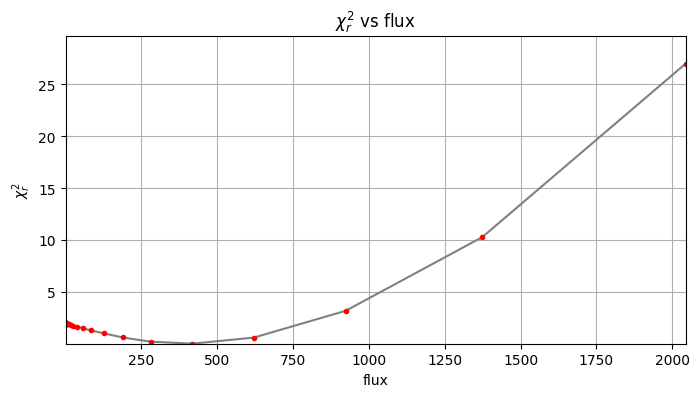

Planet 0: preliminary position guess: (r, theta)=(30.5, 240.0)
Planet 0: preliminary flux guess: 417.5
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 93, nfev: 203, chi2r: 0.05341968802209515
message: Optimization terminated successfully.
Planet 0 simplex result: (r, theta, f)=(30.485, 240.031, 404.544) at 
          (X,Y)=(34.77, 23.59)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:35.688319
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [17]:
r_0, theta_0, f_0 = firstguess(cubefc, angs, psfn, ncomp=opt_npc_ann, planets_xy_coord=[xy_test], 
                               fwhm=fwhm_naco, f_range=None, annulus_width=4*fwhm_naco, 
                               aperture_radius=2, imlib=imlib_rot, interpolation=interpolation, 
                               simplex=True, plot=True, verbose=True)

We see that using the optimal $n_{\rm pc}$ leads to closer parameter estimates to the ground truth.

<font color=green> **Answer 5.1**: If relying on a 2D Gaussian fit, both the photometry and astrometry would be biased by self-subtraction and the negative side lobes. </font>

### 5.3.2. Planet subtraction

Let's use the values obtained with the simplex optimization to subtract the planet with the function `cube_planet_free`.

First we define a list with the parameters (r, theta, flux) is each companion that we obtained via the NegFC, in this case one:

In [18]:
plpar_fc = [(r_0[0], theta_0[0], f_0[0])]

---
**NOTE**

r_0, theta_0 and f_0 have the same length as the number of planet coordinates `planets_xy_coord` provided to `firstguess`. Here there is only one planet, so we take the zeroth index. The number of tuples in `plpar_fc` should match the number of planets.

---

In [19]:
from vip_hci.fm import cube_planet_free
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, imlib=imlib_rot, interpolation=interpolation)

Let's double-check the fake companion was well removed by computing a PCA post-processed image:

In [20]:
from vip_hci.psfsub import pca_annulus
fr_pca_emp = pca_annulus(cube_emp, angs, ncomp=opt_npc_ann, annulus_width=4*fwhm_naco, 
                         r_guess=rad_fc, imlib=imlib_rot, interpolation=interpolation)


Let's take a look at the PSF of the planet in the full-frame PCA final image and the same PSF in the frame resulting of processing the planet-subtracted cube:

In [21]:
from vip_hci.preproc import frame_crop
cropped_frame1 = frame_crop(final_ann_opt, cenxy=xy_test, size=15)

New shape: (15, 15)


In [22]:
cropped_frame2 = frame_crop(fr_pca_emp, cenxy=xy_test, size=15)

New shape: (15, 15)


Let's use both `'mode=surface'` and the default image mode of `plot_frames` to show the residuals in the vicinity of the companion:

In [23]:
plot_frames((cropped_frame1, cropped_frame2), mode='surface', vmax=8)

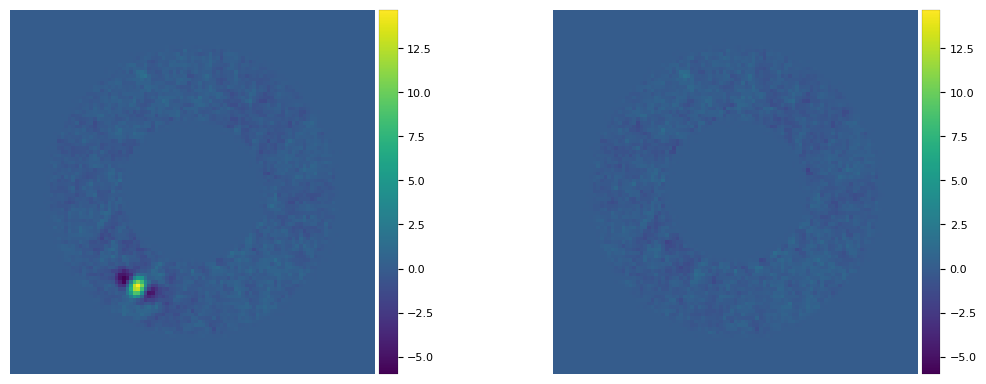

In [24]:
plot_frames((final_ann_opt, fr_pca_emp), vmin = float(np.amin(final_ann_opt)), 
            vmax= float(np.amax(final_ann_opt)), axis=False)

Not only the bright point-like signal is subtracted, but so are the negative side lobes. A subtraction not leaving any significant artifact/defect is a good sign that the inferred parameters are correct. However, keep in mind that even for slightly inaccurate parameters, the final image can still look relatively clean. Let's take for example the parameters inferred with non-optimal $n_{\rm pc}$: 

[(30.52433969170673, 240.1209758459184, 402.6266720612793)]


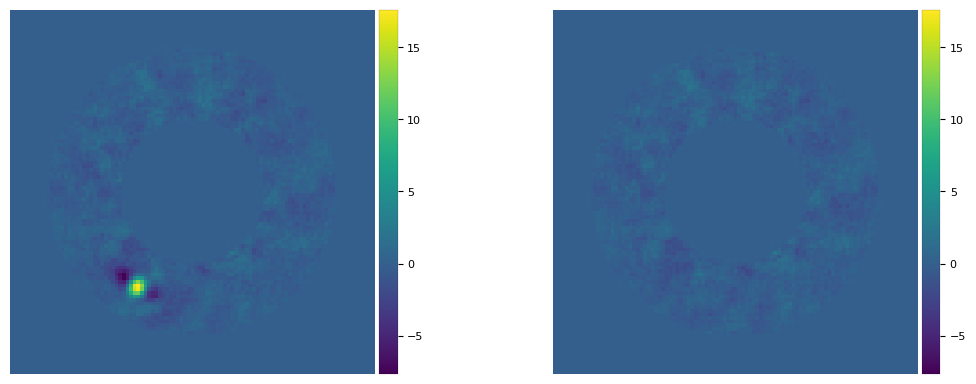

In [25]:
# planet parameters inferred from npc=5 used to make empty cube, then processed with PCA (npc=10)
plpar_fc = [(r_lo[0], theta_lo[0], f_lo[0])]
print(plpar_fc)
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, imlib=imlib_rot, interpolation=interpolation)
final_ann_5 = pca_annulus(cubefc, angs, ncomp=5, annulus_width=4*fwhm_naco, r_guess=30.5,
                                  imlib=imlib_rot, interpolation=interpolation)
fr_pca_emp5 = pca_annulus(cube_emp, angs, ncomp=5, annulus_width=4*fwhm_naco, r_guess=30.5,
                                  imlib=imlib_rot, interpolation=interpolation)
plot_frames((final_ann_5, fr_pca_emp5), vmin = float(np.amin(final_ann_5)), 
            vmax= float(np.amax(final_ann_5)), axis=False)

In [26]:
# parameters inferred from npc=25 used to make empty cube, then processed with PCA (npc=10)
plpar_fc = [(r_hi[0], theta_hi[0], f_hi[0])]
print(plpar_fc)
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, imlib=imlib_rot, interpolation=interpolation)
final_ann_25 = pca_annulus(cubefc, angs, ncomp=25, annulus_width=4*fwhm_naco, r_guess=30.5,
                                   imlib=imlib_rot, interpolation=interpolation)
fr_pca_emp25 = pca_annulus(cube_emp, angs, ncomp=25, annulus_width=4*fwhm_naco, r_guess=30.5,
                                   imlib=imlib_rot, interpolation=interpolation)
plot_frames((final_ann_25, fr_pca_emp25), vmin = float(np.amin(final_ann_25)), 
            vmax= float(np.amax(final_ann_25)), axis=False)

[(30.415536162190293, 239.9454979002353, 401.5113951627229)]


Inaccurate parameters still leading to an apparently good removal of the companion brings the question of the uncertainties on each of the three parameters characterizing the companion. The next sections are dedicated to this question. 

### 5.3.3. NEGFC technique coupled with MCMC

#### 5.3.3.1. Running the MCMC sampler

Markov Chain Monte Carlo (MCMC) is a robust way of obtaining the flux and position of the companion, and their uncertainties. 
MCMC samples the parameter space (here r and $\theta$ coordinates, and flux) using a number of *walkers* following a Markov chain (i.e. a process where each new sampled point only depends on the previous one) for a certain number of iterations.
At each iteration, a new sample of parameters is proposed to each walker to explore the parameter space (these are called *moves*), based on a given *proposal function* (e.g., the *stretch* move proposed in Goodman & Weare 2010). A criterion depending on the ratio of likelihoods calculated for the proposed vs the current parameters is then used to accept or reject the proposed moves for the next iteration (if rejected, the parameters do not change).

In our case the log-likelihood is calculated assuming that a perfect subtraction of the companion leads to pixel intensity residuals following a Gaussian distribution (centered on zero, and scaled by the standard deviation estimated in the annulus except in the area of the companion). A convergence criterion based on *autocorrelation* can be used (and is used by default in VIP) to stop iterating.
Sampling the final posterior distributions of the parameters yields both the most likely parameter values and uncertainties on each of them. 

The MCMC implementation in VIP leverages [`emcee`](https://emcee.readthedocs.io/en/stable/) ([Foreman-Mackey et al. 2013](https://ui.adsabs.harvard.edu/abs/2013PASP..125..306F/abstract); check the paper for more details on this implementation of MCMC), which is based on an efficient affine-invariant implementation of MCMC proposed in Goodman & Weare (2010).
The relevant function is `mcmc_negfc_sampling`, which can accept a number of parameters. Let's define them in the next few boxes:

Let's first define observation-related parameters, such as the non-coronagraphic psf, its FWHM and the pixel scale od the detector: 

In [27]:
obs_params = {'psfn': psfn,
              'fwhm': fwhm_naco}

In NEGFC, PCA in a single annulus is used by default to speed up the algorithm - although other algorithms can be used through the `algo` parameter. Let's set the $n_{\rm pc}$ to the optimal $n_{\rm pc}$ found in [Section 5.2](#5.2.-Generating-and-injecting-synthetic-planets). We set the width of the annulus on which PCA is performed (in pixels) with the `annulus_width` parameter. We also set a few other algorithm-related parameters in the following box:

In [28]:
annulus_width = 4*fwhm_naco

algo_params = {'algo': pca_annulus,
               'ncomp': opt_npc_ann,
               'annulus_width': annulus_width,
               'svd_mode': 'lapack',
               'imlib': imlib_rot, 
               'interpolation': interpolation}

The choice of log-likelihood expression to be used is determined by `mu_sigma` and `fmerit`. If the former is True (default; mu and sigma calculated automatically) or a tuple of 2 values provided manually (corresponding to mean and standard deviation of pixel intensities in an annulus encompassing the companion), the following figure of merit will be used: $\chi^2 = \sum_j^N \frac{(I_j-\mu)^2}{\sigma^2}$ (as introduced in [Christiaens et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.502.6117C/abstract). Otherwise, the choice will be determined by `fmerit`:
- 'sum' for the sum of absolute residuals (details in [Wertz et al. 2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...598A..83W/abstract));
- 'stddev' for the standard deviation of residuals (details in Wertz et al. 2017; which can be useful for very faint sources);
- 'hessian' for the determinant of the local Hessian matrix (which containes 2nd order derivatives with respect to spatial coordinates) - the latter being useful when the point source is contained within a more extended signal (see e.g. [Christiaens et al. 2024](https://ui.adsabs.harvard.edu/abs/2024arXiv240304855C/abstract)).
  
Another parameter to set is `aperture_radius`, which is the radius of the aperture  (in `fwhm` units) in which the residual intensities $I_j$ are considered.

In [29]:
mu_sigma=True
aperture_radius=2

negfc_params = {'mu_sigma': mu_sigma,
                'aperture_radius': aperture_radius}

Parameter ``initial_state`` corresponds to the initial first estimation of the planets parameters (r, theta, flux). We set it to the result of the simplex optimization, obtained with optimal $n_{\rm pc}$.

---
**NOTE**

The MCMC minimization can only run for one companion candidate at a time, hence the first dimension of init should always be 3 (not the number of planets, as opposed to `planets_xy_coord` in `firstguess`).

---

In [30]:
initial_state = np.array([r_0[0], theta_0[0], f_0[0]])

Beware that the MCMC procedure is a CPU intensive procedure and can take several hours when run properly on a standard laptop. We use the affine invariant sampler from `emcee` which can be run in parallel (`nproc` sets the number of CPUs to be used). At least 100 walkers are recommended for our MCMC chain, although both the number of walkers and iterations will depend on your dataset. 
For the sake of preventing this tutorial to take too long to run, we set the maximum number of iterations to 500, although feel free to significantly increase it in case of non-convergence.

In [31]:
from multiprocessing import cpu_count

nwalkers, itermin, itermax = (100, 200, 500)

mcmc_params = {'nwalkers': nwalkers,
               'niteration_min': itermin,
               'niteration_limit': itermax,
               'bounds': None,
               'nproc': cpu_count()//2}


Another update from Christiaens et al. (2021) is that the convergence can now be evaluated based on the auto-correlation time (see more details in the [documentation of `emcee`](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/)), instead of the Gelman-Rubin test, which is inappropriate for non-independent samples (such as an MCMC chain).
We set the convergence test to the autocorrelation time based criterion using `conv_test='ac'` (instead of Gelman-Rubin 'gb'). We also set the autocorrelation criterion $N/\tau >= a_c$, where $N$ is the number of samples and $\tau$ the autocorrelation time, to `ac_c=50` (the value recommended in the `emcee` documentation). Finally, we set the number of consecutive times the criterion must be met to: `ac_count_thr=1`, and the maximum gap in number of steps between 2 checks of the convergence criterion to: `check_maxgap=50`. If the maximum number of iterations `niteration_limit` is large enough, the chain will stop upon meeting the convergence criterion (spoiler: it won't be the case here since we chose a small value for `niteration_limit`).

In [32]:
conv_test, ac_c, ac_count_thr, check_maxgap = ('ac', 50, 1, 50)

conv_params = {'conv_test': conv_test,
               'ac_c': ac_c,
               'ac_count_thr': ac_count_thr,
               'check_maxgap': check_maxgap}

Setting `bounds=None` does *not* mean no bounds are used for parameter exploration, but rather that they are set automatically to:

- $r \in [r_0-w_{ann}/2, r_0+w_{ann}/2]$, where $w_{ann}$ is the `annulus_width`,
- $\theta \in [\theta_0-\Delta {\rm rot}, \theta_0+\Delta {\rm rot}]$, where $\Delta {\rm rot}$ is the angle subtended by min(`aperture_radius`/2,`fwhm`) at $r_0$,
- $f \in [0.1*f_0, 2*f_0]$,

where ($r_0, \theta_0, f_0$) = `initial_state`.
If the `bounds` are provided manually (as a tuple of tuples), they will supersede the automatic setting above.

Now let's start the sampler. Note that this step is computer intensive and may take a long time to run depending on your machine. Feel free to skip the next cell if you do not wish to run the MCMC or can't run it in a reasonable time. The results are already saved as 'MCMC_results' in the 'datasets' folder and will be loaded in the subsequent boxes.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-26 00:31:48
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
        MCMC sampler for the NEGFC technique       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
The mean and stddev in the annulus at the radius of the companion (excluding the PA area directly adjacent to it) are -0.11 and 1.91 respectively.
Beginning emcee Ensemble sampler...
emcee Ensemble sampler successful

Start of the MCMC run ...
Step  |  Duration/step (sec)  |  Remaining Estimated Time (sec)
0		4.67933			2334.98467
1		3.74638			1865.69575
2		3.72469			1851.16845
3		3.69502			1832.72942
4		3.74728			1854.90212
5		3.78942			1871.97447
6		3.83033			1888.35170
7		3.77518			1857.38905
8		3.70591			1819.60034
9		3.75779			1841.31465
10		3.69553			1807.11564
11		3.68184			1796.73743
12		3.70973			1806.64046
13		3.77245			1833.41167
14		3.78166			1834.106

51		3.86112			1729.78131
52		3.66715			1639.21784
53		3.75568			1675.03462
54		3.75262			1669.91679
55		3.69319			1639.77858
56		3.88141			1719.46286
57		3.70450			1637.38812
58		3.67922			1622.53514
59		3.59321			1581.01460
60		3.69739			1623.15245
61		3.69642			1619.03196
62		3.80197			1661.46220
63		3.77312			1645.07901
64		3.79861			1652.39535
65		3.69582			1603.98371
66		3.69055			1598.00772
67		3.66079			1581.45955
68		3.72789			1606.71887
69		3.77428			1622.94212
70		3.68503			1580.87744
71		3.90015			1669.26506
72		3.69125			1576.16546
73		3.72758			1587.94738
74		3.76218			1598.92608
75		3.80940			1615.18772
76		3.78174			1599.67560
77		4.03133			1701.22295
78		4.02550			1694.73634
79		3.73347			1568.05908
80		4.03759			1691.75063
81		3.79961			1588.23865
82		3.84846			1604.80782
83		3.81993			1589.09254
84		3.77626			1567.14790
85		3.93245			1628.03347
86		3.78009			1561.17882
87		3.86868			1593.89575
88		4.11157			1689.85650
89		3.96946			1627.47778
90		3.86380			1580.29297


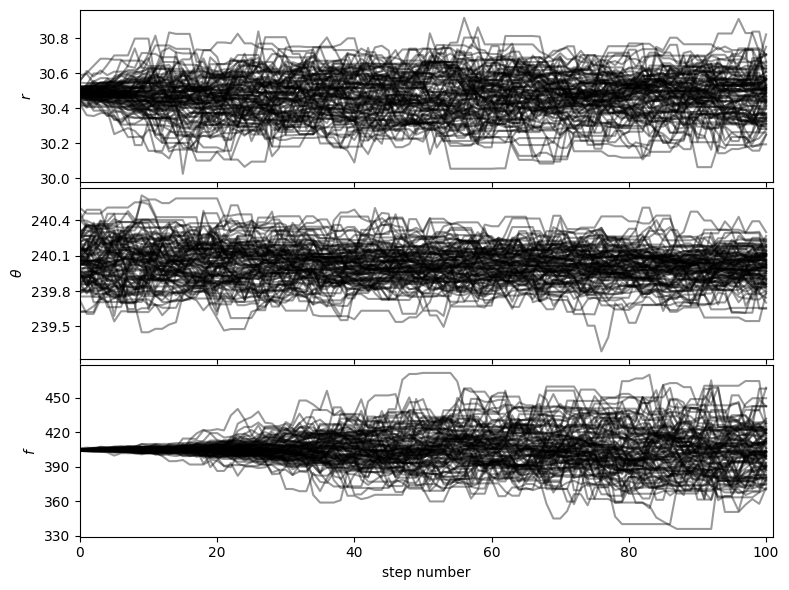

101		3.93199			1564.93122
102		3.70681			1471.60238
103		3.77023			1493.01068
104		3.67673			1452.30875
105		3.68877			1453.37617
106		3.69146			1450.74535
107		3.68723			1445.39220
108		3.74330			1463.63030
109		3.80973			1485.79665
110		3.77487			1468.42365
111		3.90659			1515.75886
112		3.75022			1451.33591
113		3.73326			1441.03720
114		3.77634			1453.88974
115		3.76211			1444.64870
116		3.73245			1429.52873
117		3.78885			1447.34146
118		3.68469			1403.86689
119		3.76521			1430.77904
120		3.68730			1397.48632
121		3.71669			1404.90995
122		3.65112			1376.47224
123		3.70777			1394.12077
124		3.69306			1384.89563
125		3.71067			1387.78871
126		3.79145			1414.21122
127		3.70668			1378.88608
128		3.69725			1371.68012
129		3.82984			1417.04043
130		3.72761			1375.48772
131		3.67849			1353.68616
132		3.64512			1337.75977
133		3.66435			1341.15210
134		3.87021			1412.62811
135		3.65552			1330.60819
136		3.76853			1367.97675
137		3.71162			1343.60644
138		3.65331			1318.84419
139		3.70705

151		4.18220			1455.40490
152		3.67940			1276.75284
153		3.65065			1263.12352
154		3.68976			1272.96617
155		3.70908			1275.92524
156		3.76145			1290.17666
157		3.74829			1281.91552
158		3.71551			1266.99061
159		3.70559			1259.90060
160		3.71027			1257.78051
161		3.64383			1231.61589
162		3.81980			1287.27092
163		3.71129			1246.99378
164		3.70950			1242.68350
165		3.70225			1236.55284
166		3.75776			1251.33408
167		3.83048			1271.72036
168		3.65457			1209.66234
169		3.71160			1224.82668
170		3.66088			1204.43116
171		3.71227			1217.62390
172		3.79538			1241.08893
173		3.81336			1243.15503
174		3.90436			1268.91570
175		3.86290			1251.57863
176		3.72057			1201.74508
177		3.67514			1183.39411
178		3.68449			1182.71969
179		3.71312			1188.20000
180		3.71258			1184.31430
181		3.81661			1213.68039
182		3.69779			1172.19975
183		3.69262			1166.86918
184		3.68606			1161.10764
185		3.79154			1190.54450
186		3.71366			1162.37683
187		3.75070			1170.21965
188		3.84512			1195.83325
189		3.76926

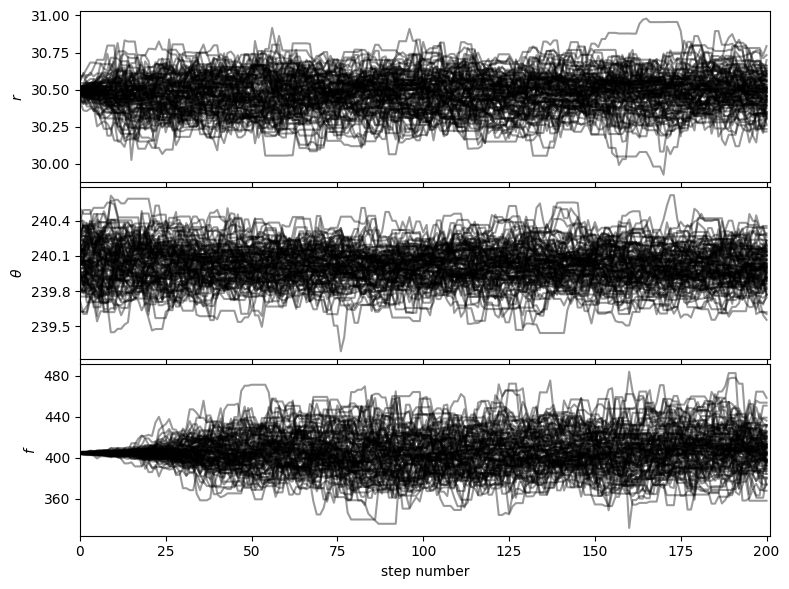

Auto-corr tau/N = [0.0679942  0.07448097 0.06289897]
tau/N <= 0.02 = [False False False] 

201		4.11104			1225.08843
202		3.69734			1098.11146
203		3.72829			1103.57502
204		3.84626			1134.64611
205		3.75331			1103.47167
206		3.73777			1095.16690
207		3.79210			1107.29174
208		3.75526			1092.78008
209		3.74581			1086.28635
210		3.70649			1071.17445
211		3.72604			1073.10038
212		3.72992			1070.48589
213		3.67216			1050.23719
214		3.84512			1095.85948
215		3.83460			1089.02725
216		3.72182			1053.27421
217		3.68887			1040.26106
218		3.70251			1040.40503
219		3.80024			1064.06608
220		3.74797			1045.68391
221		3.83778			1066.90256
222		3.73339			1034.14986
223		3.75684			1036.88729
224		3.65747			1005.80453
225		3.66277			1003.59898
226		3.78506			1033.32193
227		3.74414			1018.40526
228		3.70013			1002.73523
229		3.69294			997.09272
230		3.65010			981.87717
231		3.66737			982.85409
232		3.67341			980.80100
233		3.66254			974.23617
234		3.71140			983.52047
235		3.71121			979.75944
236		3

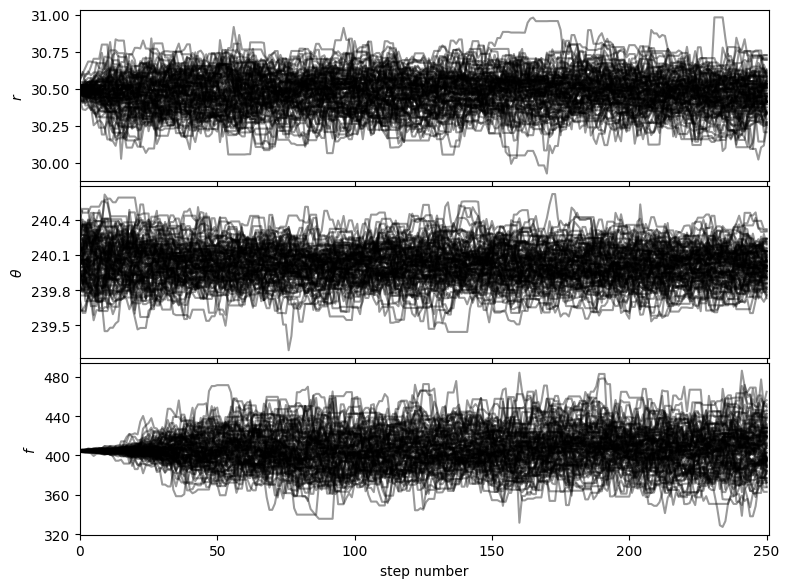

Auto-corr tau/N = [0.06297589 0.06731291 0.05644879]
tau/N <= 0.02 = [False False False] 

251		3.99689			991.22847
252		3.75812			928.25465
253		3.67617			904.33708
254		3.85785			945.17399
255		3.76486			918.62560
256		3.81698			927.52638
257		3.74492			906.27064
258		3.66318			882.82566
259		3.63869			873.28440
260		3.63176			867.99088
261		3.67512			874.67761
262		3.67523			871.02856
263		3.69969			873.12613
264		3.77005			885.96269
265		3.67885			860.85113
266		3.68810			859.32823
267		3.66130			849.42206
268		3.81635			881.57708
269		3.77393			868.00321
270		3.73869			856.16116
271		3.69881			843.32777
272		3.70014			839.93246
273		3.67018			829.46158
274		3.69924			832.32922
275		3.66537			821.04355
276		3.91223			872.42774
277		3.76496			835.82179
278		3.77894			835.14596
279		3.65312			803.68618
280		3.68510			807.03646
281		3.68645			803.64566
282		3.78947			822.31521
283		3.74320			808.53142
284		3.72511			800.89887
285		3.72136			796.37104
286		3.82323			814.34842
287		3.72

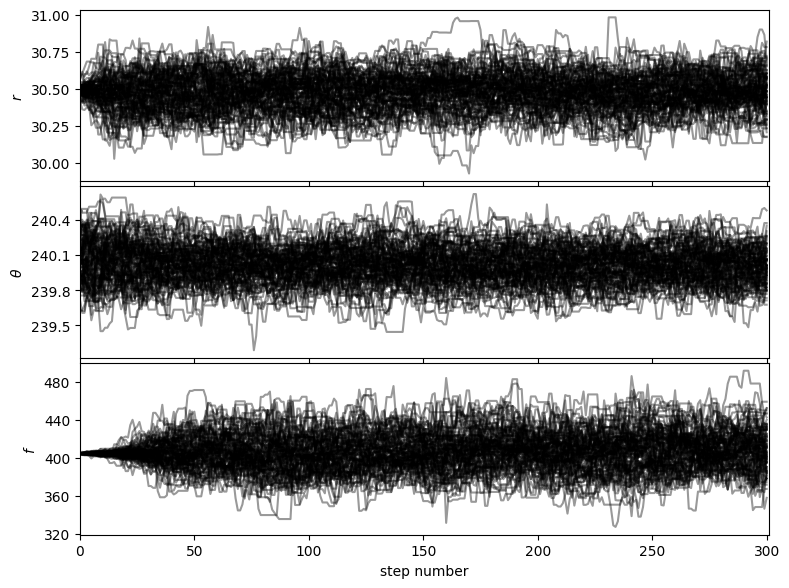

Auto-corr tau/N = [0.05882983 0.06192013 0.05042843]
tau/N <= 0.02 = [False False False] 

301		4.28147			847.73086
302		3.84794			758.04339
303		3.70474			726.12865
304		3.81795			744.50064
305		3.72423			722.50004
306		3.68127			710.48434
307		3.70470			711.30182
308		3.80799			727.32628
309		3.73768			710.15863
310		3.70319			699.90367
311		3.71828			699.03589
312		3.78172			707.18127
313		3.83518			713.34255
314		3.82240			707.14382
315		3.74302			688.71531
316		3.83277			701.39673
317		3.74246			681.12772
318		3.73299			675.67155
319		3.74093			673.36704
320		3.69307			661.06043
321		3.67227			653.66406
322		3.72301			658.97312
323		3.72319			655.28197
324		3.75482			657.09332
325		3.68113			640.51575
326		3.82390			661.53418
327		3.67272			631.70836
328		3.66962			627.50434
329		3.65191			620.82402
330		3.68062			622.02410
331		3.68545			619.15594
332		3.81646			637.34815
333		3.81071			632.57753
334		3.74564			618.03076
335		3.68306			604.02233
336		3.81316			621.54459
337		3.82

Auto-corr tau/N = [0.05643874 0.05798973 0.04822743]
tau/N <= 0.02 = [False False False] 

351		4.45988			660.06268
352		3.98904			586.38917
353		3.66486			535.06912
354		3.67007			532.16044
355		3.64280			524.56291
356		3.70832			530.29033
357		3.71098			526.95959
358		3.66515			516.78671
359		3.72444			521.42104
360		3.71800			516.80242
361		3.78775			522.70964
362		3.72004			509.64575
363		3.72562			506.68446
364		3.74057			504.97735
365		3.76503			504.51415
366		3.77191			501.66416
367		3.76621			497.14038
368		3.75643			492.09168
369		3.67892			478.25960
370		3.68151			474.91518
371		3.68132			471.20858
372		3.79606			482.09987
373		3.75099			472.62461
374		3.71992			464.99000
375		3.73770			463.47530
376		3.97907			489.42549
377		3.76344			459.13980
378		3.67870			445.12222
379		3.65562			438.67380
380		3.72709			443.52312
381		3.72370			439.39648
382		3.67279			429.71666
383		3.65670			424.17662
384		3.83634			441.17899
385		3.66705			418.04359
386		3.77326			426.37827
387		3.90

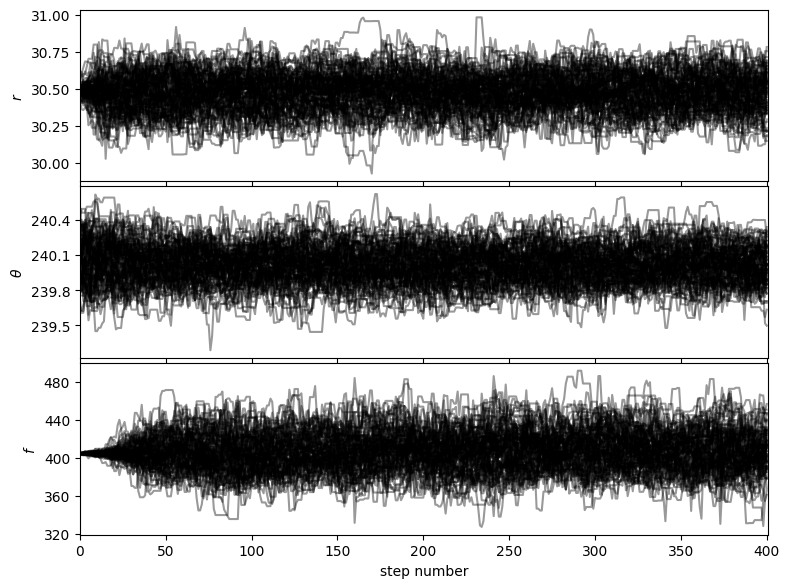

Auto-corr tau/N = [0.05282663 0.05336362 0.04362362]
tau/N <= 0.02 = [False False False] 

401		4.26088			417.56644
402		3.78558			367.20107
403		3.77377			362.28144
404		3.67839			349.44676
405		3.74845			352.35439
406		3.65696			340.09691
407		3.70541			340.89754
408		3.68059			334.93387
409		3.65853			329.26770
410		3.78401			336.77725
411		3.79393			333.86549
412		3.84589			334.59226
413		3.86364			332.27278
414		3.74094			317.98007
415		3.88656			326.47087
416		3.86842			321.07878
417		3.77002			309.14139
418		3.85855			312.54255
419		3.73472			298.77792
420		3.72737			294.46223
421		3.72380			290.45609
422		3.67763			283.17736
423		3.76358			286.03208
424		3.69203			276.90202
425		3.67574			272.00476
426		3.89212			284.12476
427		3.91004			281.52281
428		3.84315			272.86393
429		4.11575			288.10243
430		3.75732			259.25515
431		4.09172			278.23703
432		3.90482			261.62314
433		4.03035			266.00317
434		3.79380			246.59687
435		3.94292			252.34720
436		3.81343			240.24584
437		3.85

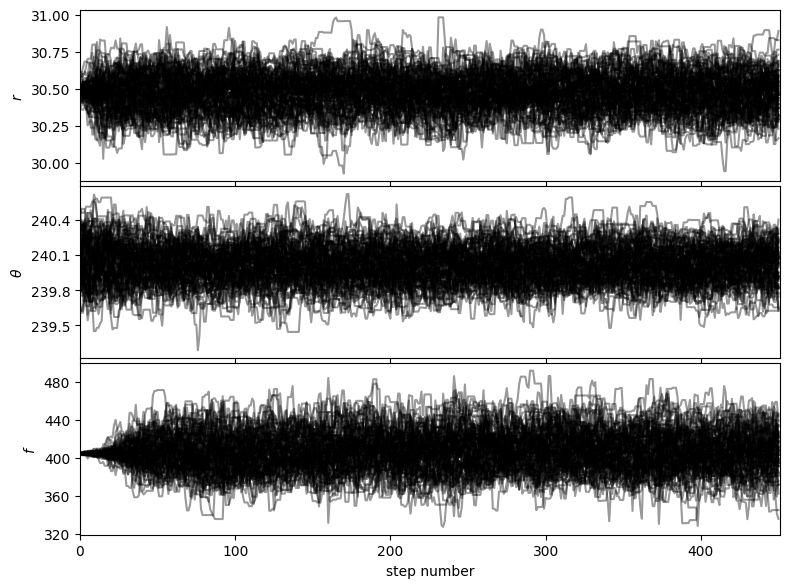

Auto-corr tau/N = [0.04777104 0.0489981  0.04145926]
tau/N <= 0.02 = [False False False] 

451		3.97946			191.01418
452		3.70319			174.04988
453		3.74735			172.37819
454		3.75651			169.04290
455		3.67658			161.76930
456		3.66209			157.46991
457		3.95949			166.29841
458		3.65751			149.95799
459		3.84934			153.97360
460		4.09859			159.84485
461		4.10657			156.04951
462		3.99442			147.79350
463		3.74376			134.77518
464		3.78320			132.41193
465		3.80384			129.33059
466		3.85738			127.29364
467		3.77298			120.73526
468		3.67803			114.01896
469		3.81074			114.32226
470		4.12536			119.63553
471		3.75978			105.27387
472		4.01060			108.28615
473		3.83008			99.58216
474		3.86824			96.70610
475		3.73332			89.59973
476		3.78296			87.00813
477		3.72047			81.85034
478		3.75768			78.91128
479		3.70115			74.02304
480		3.71619			70.60767
481		3.71724			66.91030
482		3.68625			62.66622
483		3.69352			59.09638
484		3.74258			56.13869
485		3.70847			51.91857
486		3.69873			48.08353
487		3.70337			44.44050

In [33]:
from vip_hci.fm import mcmc_negfc_sampling
chain = mcmc_negfc_sampling(cubefc, angs, **obs_params, **algo_params, **negfc_params, 
                            initial_state=initial_state, **mcmc_params, **conv_params,
                            display=True, verbosity=2, save=False, output_dir='./')

If you ran the previous box and wish to write your results, set `write=True` in the next box. This will pickle the MCMC chain.

In [34]:
write=False

if write:
    import pickle
    output = {'chain':chain}
    with open('../datasets/my_MCMC_results', 'wb') as fileSave:
        pickle.dump(output, fileSave)

---
**NOTE**

An alternative to the cell above, is to provide `output_dir` in the call to `mcmc_negfc_sampling` and set `save` to True. This will save the results as a pickle including additional keys: apart from 'chain', it will also save 'input_parameters', 'AR' (acceptance ratio), and 'lnprobability'.

---

Pickled results can be loaded from disk like this:

In [33]:
import pickle
with open('../datasets/MCMC_results','rb') as fi:
    myPickler = pickle.Unpickler(fi)
    mcmc_result = myPickler.load()

print(mcmc_result.keys())
chain = mcmc_result['chain']

dict_keys(['chain', 'input_parameters', 'AR', 'lnprobability'])


The most accurate approach would involve setting a large enough maximum number of iterations and using FFT-based rotation for PCA. The latter in particular, may change a bit the most likely parameter values given the better flux conservation. However, these changes would involve over ~3 orders of magnitude longer calculation time. It is therefore intractable for a personal laptop and not shown in this notebook. If you have access to a supercomputer feel free to adopt these changes though. The results after 500 iterations are nonetheless good enough for illustrative purpose:

#### 5.3.3.2. Visualizing the MCMC chain: corner plots and walk plots 

Let's first check that the walk plots look ok:

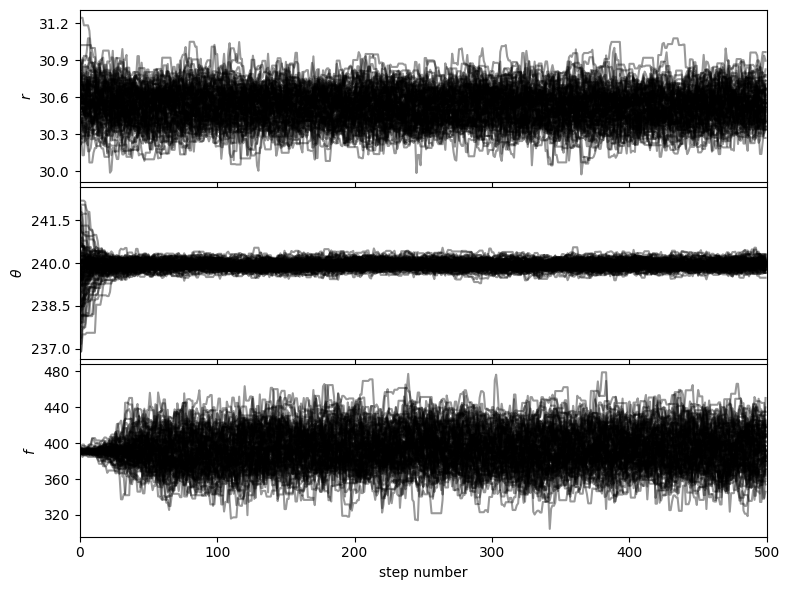

In [34]:
from vip_hci.fm import show_walk_plot
show_walk_plot(chain)

Then based on the walk plot, let's burn-in the first 30% of the chain (to only keep the iterations where the walkers appear to have mostly converged), to calculate the corner plots:

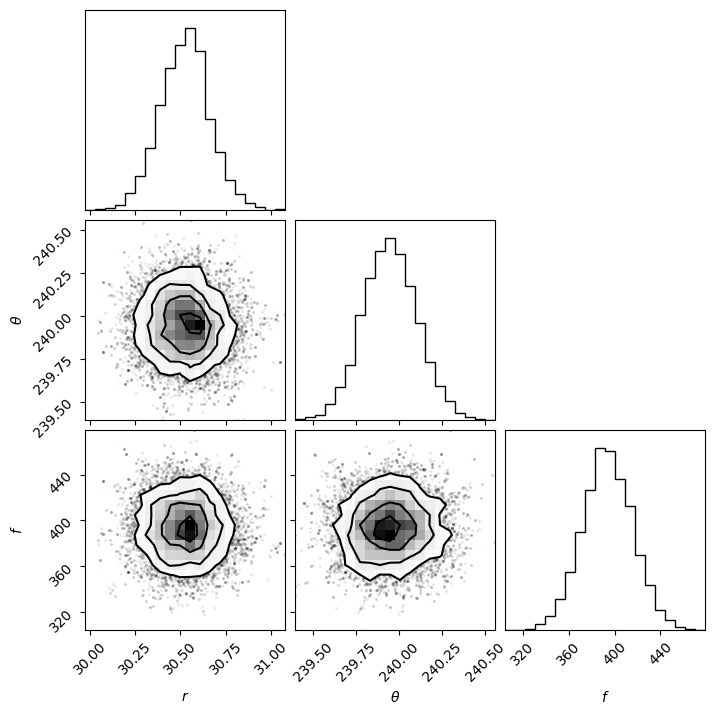

In [35]:
from vip_hci.fm import show_corner_plot
burnin = 0.3
burned_chain = chain[:, int(chain.shape[1]//(1/burnin)):, :]
show_corner_plot(burned_chain)

For the purpose of this tutorial and to limit computation time we set the maximum number of iterations to 500 for 100 walkers. The look of the corner plots may improve with more samples (i.e. higher number of iterations, for a given burn-in ratio). This can be tested by setting the max. number of iterations arbitrarily high for the autocorrelation-time convergence criterion to be met.

#### 5.3.3.3. Highly probable values and confidence intervals 

Now let's determine the most highly probable value for each model parameter, as well as the 1-sigma confidence interval. For this, let's first flatten the chains:

In [36]:
isamples_flat = chain[:, int(chain.shape[1]//(1/burnin)):, :].reshape((-1,3))

Then use the `confidence` function:

percentage for r: 69.79202279202278%
percentage for theta: 69.02279202279202%
percentage for f: 68.94017094017094%


Confidence intervals:
r: 30.57489764243517 [-0.20421878422770945,0.08279139901123145]
theta: 239.91771004343246 [-0.14527599962792692,0.18317408648738365]
f: 390.7650582608513 [-20.054061636888093,25.285555976945886]


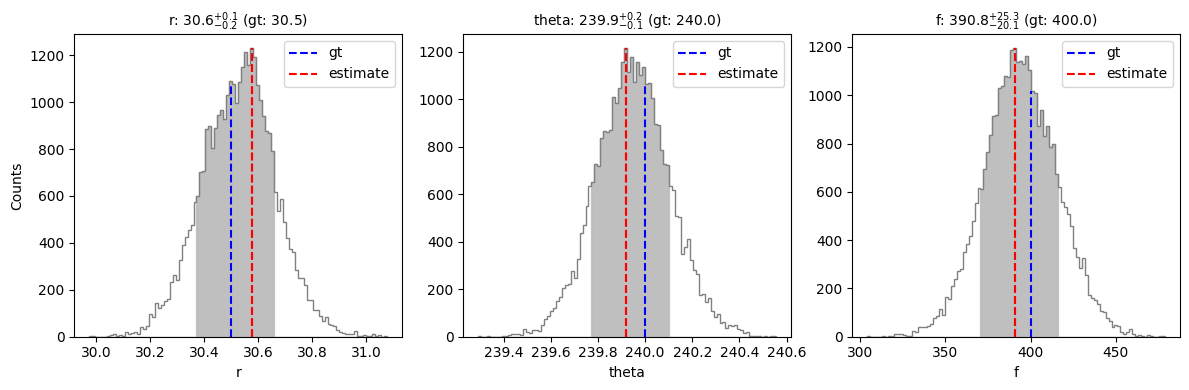

In [37]:
from vip_hci.fm import confidence
val_max, conf = confidence(isamples_flat, cfd=68, gaussian_fit=False, verbose=True, save=False, 
                           gt=gt, ndig=1, title=True)

Using the `confidence` function with the `gaussian_fit=True` option, it is possible to fit a Gaussian to the posterior distribution of each parameter, and infer associated uncertainty values.

percentage for r: 69.79202279202278%
percentage for theta: 69.02279202279202%
percentage for f: 68.94017094017094%


Confidence intervals:
r: 30.57489764243517 [-0.20421878422770945,0.08279139901123145]
theta: 239.91771004343246 [-0.14527599962792692,0.18317408648738365]
f: 390.7650582608513 [-20.054061636888093,25.285555976945886]

Gaussian fit results:
r: 30.525747462344565 +-0.13676103149725966
theta: 239.94793373875024 +-0.15744912409220196
f: 394.1338634773366 +-21.669634439677626


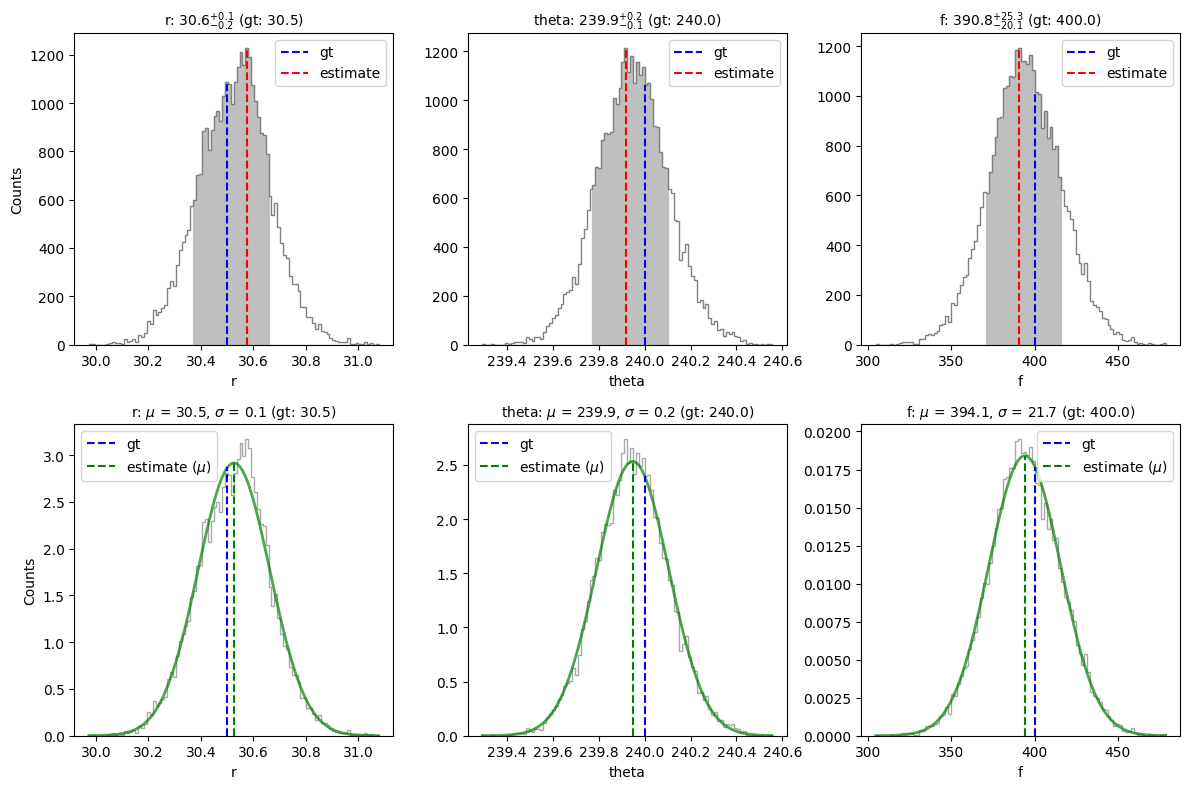

In [38]:
mu, sigma = confidence(isamples_flat, cfd=68, gaussian_fit=True, verbose=True, save=False, 
                       gt=gt, ndig=1, title=True)

It is recommended to report the results as confidence intervals (i.e. with possibly asymmetric uncertainties) as long as the bin interval is small enough. Here, we also fitted the residual posterior distribution of each parameter to a Gaussian distribution (this shape is the expected one if the noise has been well whitened, but is not necessarily guaranteed at all separations depending on the adopted $n_{\rm pc}$). In case these distributions look Gaussian, the inferred $\sigma$ value may be a more accurate uncertainty value for the different parameters.

We can see that the confidence intervals inferred by NEGFC for the different parameters encompass the ground truth values used for injection (in particular for the flux). 

---
**NOTE**

Depending on your choice of `mu_sigma`, you may have to calculate separately another source of uncertainty. Indeed, with the original expression for $\chi^2$ (Wertz et al. 2017; `mu_sigma=False`), only the uncertainty associated to *photon noise* was reflected in the MCMC results. With the new expression (`mu_sigma=True`), the $\chi^2$ expression also takes into account the *residual speckle noise* at the radial separation of the companion candidate (at least if `sigma='spe+pho'` in the call, which is the default). Our tests on this dataset suggest that similar final uncertainties can be obtained in either of these 2 ways:  

- the uncertainties obtained with MCMC when setting `mu_sigma=True` and `sigma='spe+pho'`;  
- the uncertainties obtained by combining quadratically the uncertainties obtained with MCMC (setting `mu_sigma=False` and `fmerit = 'sum'`), and the residual speckle uncertainties inferred as in [Sec. 5.3.5](#5.3.5.-Residual-speckle-uncertainty) (Wertz et al. 2017).  

---

### 5.3.4. NEGFC technique coupled with nested sampling

Nested sampling can be a faster approach to estimate the optimal parameters, given a good first guess estimate.

The implementation in VIP relies on ``nestle`` ([Barbary 2013](https://github.com/kbarbary/nestle); more details [here](http://kylebarbary.com/nestle/)).

The procedure is essentially the same as for the MCMC sampler. Let's first set the parameters associated with the observation:

In [39]:
obs_params = {'psfn': psfn,
              'fwhm': fwhm_naco}

Let's then set the parameters associated with ``pca_annulus``, the PSF modeling and subtraction algorithm:

In [40]:
annulus_width = 4*fwhm_naco

algo_params = {'algo': pca_annulus,
               'ncomp': opt_npc_ann,
               'annulus_width': annulus_width,
               'svd_mode': 'lapack'}
algo_options = {'imlib': imlib_rot, 
                'interpolation': interpolation}

For a change, let's consider `fmerit='sum'` for the choice of log-likelihood expression, hence set `mu_sigma=False`. Let's keep an `aperture_radius` of 2 FWHM.

In [41]:
aperture_radius=2
mu_sigma = False
fmerit = 'sum'

negfc_params = {'mu_sigma': mu_sigma,
                'fmerit': fmerit,
                'aperture_radius': aperture_radius}

Let's define our first guess on the parameters as the ``initial_state``:

In [42]:
initial_state = np.array([r_0[0], theta_0[0], f_0[0]])

Let's now define the parameters of the nested sampling algorithm. These are a bit different from MCMC:

- `npoints` sets the number of live points (similar to walkers in MCMC);
- `dlogz` is related to a criterion used to stop the iterations. Iterations will stop when the estimated contribution of the remaining prior volume to the total evidence falls below this threshold. Explicitly, the stopping criterion is log($z$ + $z_{\rm est}$) - log($z$) < $dlogz$ where $z$ is the current evidence from all saved samples, and $z_{\rm est}$ is the estimated contribution from the remaining volume. Typical good values: 0.1 or 0.5;
- `decline_factor` is related to an alternative criterion to stop the iterations. Iterations will stop when the weight (likelihood times prior volume) of newly saved samples has been declining for decline_factor * nsamples consecutive samples. A value of 1.0 yields good results on this dataset.
- `w` are the windows that will bound the exploration space for each parameter. These should be provided in the respective units of each input parameter.
- `rstate` can be used to specify a given random state to start with.

In [43]:
npoints = 100
dlogz, decline_factor = (0.1, None)
rstate = None
w = (5, 5, 200)

nested_params = {'npoints': nwalkers,
                 'dlogz': dlogz,
                 'decline_factor': None,
                 'rstate': rstate,
                 'w': w}

Now let's start the sampler. Note that this step is computer intensive and may take a few minutes to run depending on your machine (but typically goes 4-5x faster than MCMC with 500 iterations considering the aboved parameters).

In [44]:
from vip_hci.fm import nested_negfc_sampling
nested_res = nested_negfc_sampling(initial_state, cubefc, angs, **obs_params, **algo_params, algo_options=algo_options,
                              **negfc_params, **nested_params, verbose=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-26 01:10:32
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Prior bounds on parameters:
Radius [25.485108459103685,35.485108459103685]
Theta [235.0305578125488,245.0305578125488]
Flux [204.54399596690672,604.5439959669068]

Using 100 active points

Total running time:
Running time:  0:06:41.569444
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


The results of the nested sampling as stored in a nestle object. The results can be conveniently inferred using the aptly named `nested_sampling_results` function, which can also write the results (through `save` and `output_dir` arguments):

niter: 1370
ncall: 2782
nsamples: 1470
logz: -62.380 +/-  0.306
h:  9.362

Natural log of prior volume and Weight corresponding to each sample


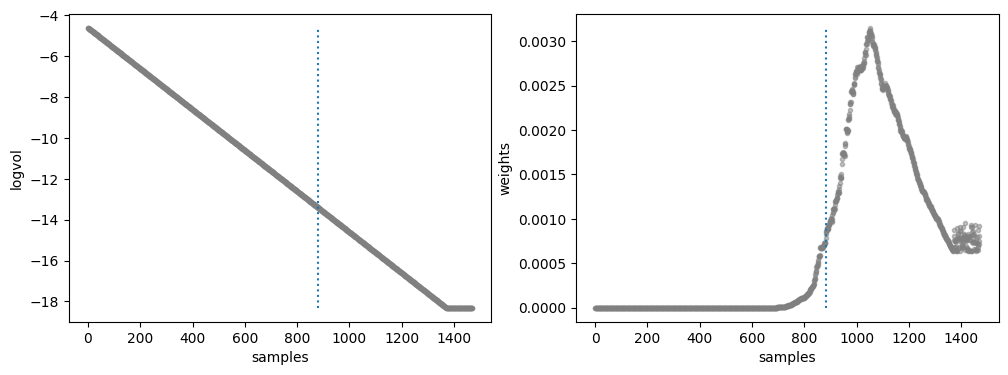


Walk plots before the burnin

Walk plots after the burnin


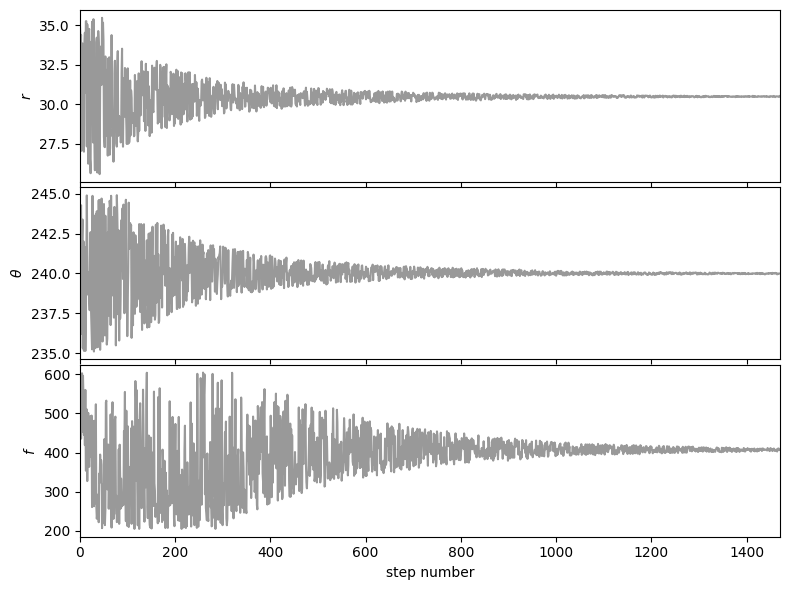

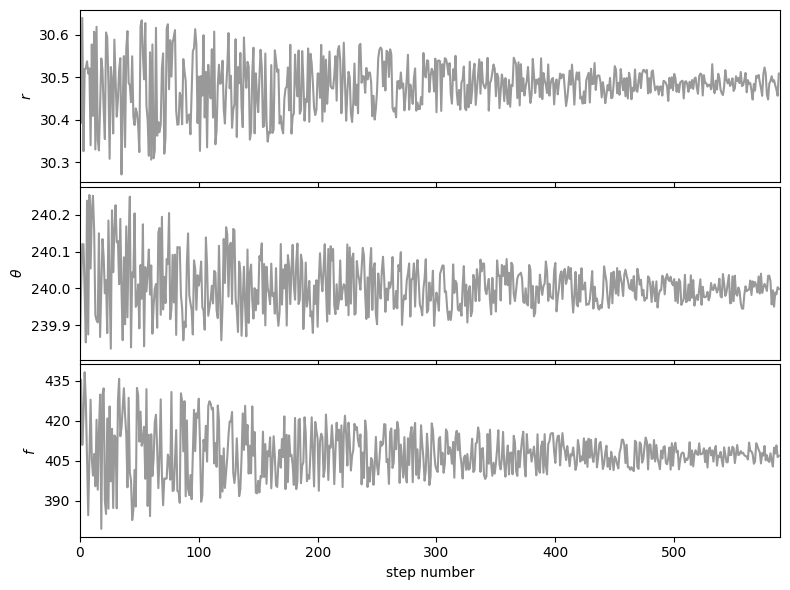


Weighted mean +- sqrt(covariance)
Radius = 30.479 +/- 0.064
Theta = 240.006 +/- 0.071
Flux = 407.892 +/- 9.386

Hist bins = 24

Confidence intervals
percentage for r: 70.33529165480141%
percentage for theta: 71.59451696713656%
percentage for f: 70.49362534314926%


Confidence intervals:
r: 30.49359600488267 [-0.09972337298495404,0.05369720083805163]
theta: 239.96120315948127 [-0.044221430001499584,0.11497571800393303]
f: 407.60520209708034 [-13.496632905881825,8.588766394652168]

Gaussian fit results:
r: 30.480293430429295 +-0.05934716723598515
theta: 240.0063310083186 +-0.06807952983059093
f: 407.87844951803083 +-8.914065340527006


array([[3.04785035e+01, 6.40976163e-02],
       [2.40006332e+02, 7.06865973e-02],
       [4.07892189e+02, 9.38609668e+00]])

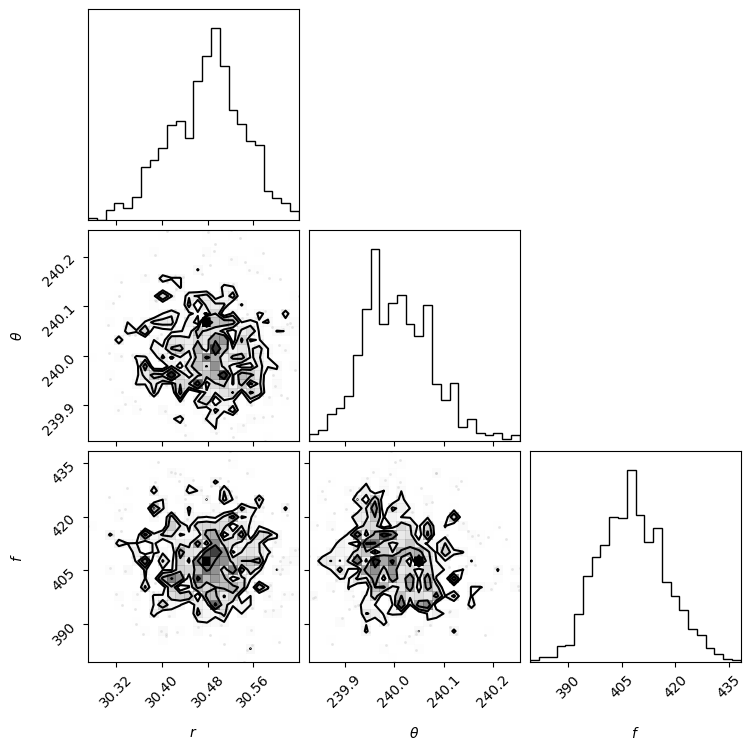

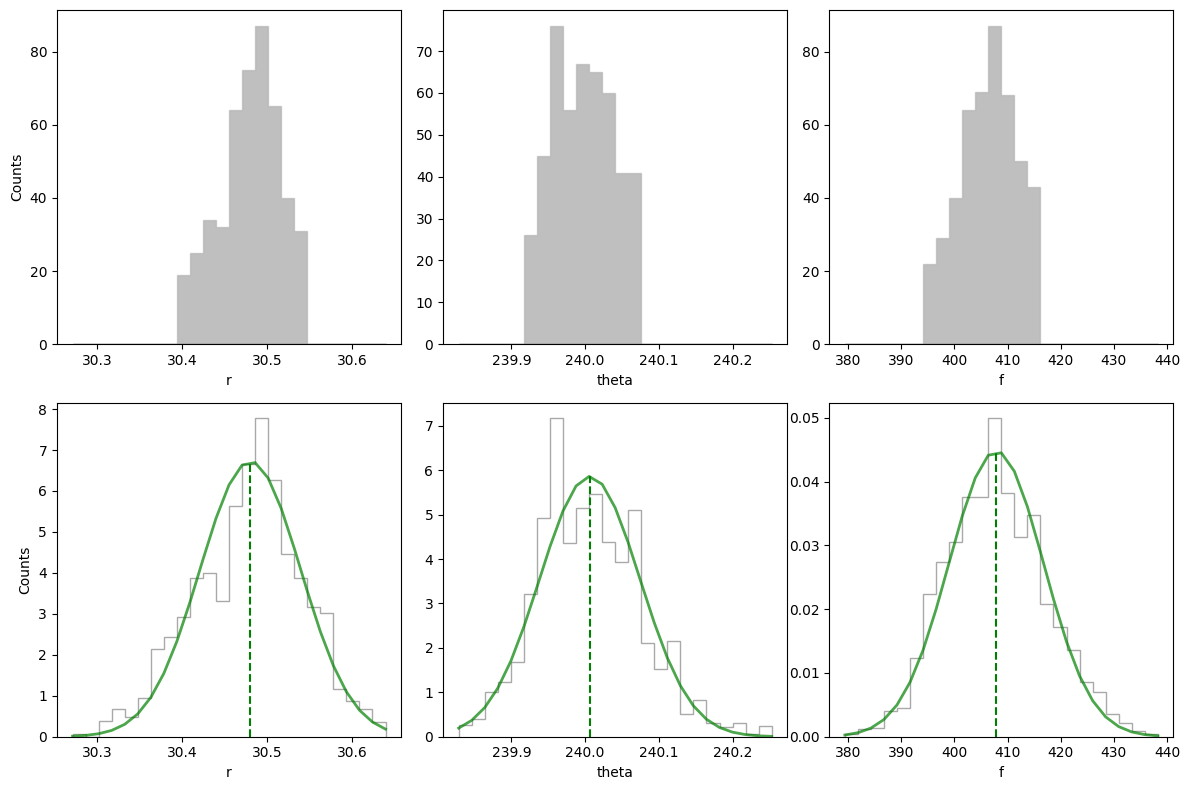

In [46]:
from vip_hci.fm import nested_sampling_results
nested_sampling_results(nested_res, burnin=0.6, bins=None, plot=True, save=True, output_dir='../datasets/')

As a reminder the ground truth values are:

In [47]:
gt

[30.5, 240, 400.0]

The final posterior distributions on the three parameters appear thus reasonable.

### 5.3.5. Residual speckle uncertainty

**Only needed if using `mu_sigma=False` in your call to mcmc_negfc_sampling!**

Residual speckle noise can bias the best parameter estimates found for the companion (if not taken into account in the MCMC).
To evaluate the uncertainty associated to this additional source of noise, it is recommended to inject a large number of fake companions at the same radius and flux as estimated for the true companion but different azimuths, and then estimate their parameters using simplex-NEGFC. The distribution of differences with respect to injected parameters can then give us an idea of the *residual speckle noise uncertainty*. This is done in VIP with the `speckle_noise_uncertainty` function (see also Sec. 3.3 in Wertz et al. 2017 for more details).

Let's use the planet parameters inferred by the MCMC-NEGFC algorithm:

In [48]:
pl_par = (val_max['r'],val_max['theta'],val_max['f'])
pl_par

(30.57489764243517, 239.91771004343246, 390.7650582608513)


#######################################################
###            SPECKLE NOISE DETERMINATION          ###
#######################################################

Number of steps: 360

Process is running for angle: 0.00
Process is running for angle: 18.00Process is running for angle: 36.00

Process is running for angle: 54.00
Process is running for angle: 72.00
Process is running for angle: 1.00
Process is running for angle: 19.00
Process is running for angle: 73.00
Process is running for angle: 37.00
Process is running for angle: 55.00
Process is running for angle: 2.00
Process is running for angle: 74.00
Process is running for angle: 38.00
Process is running for angle: 20.00
Process is running for angle: 56.00
Process is running for angle: 75.00
Process is running for angle: 3.00
Process is running for angle: 39.00
Process is running for angle: 57.00
Process is running for angle: 21.00
Process is running for angle: 4.00
Process is running for angle: 76.00
Process is running fo

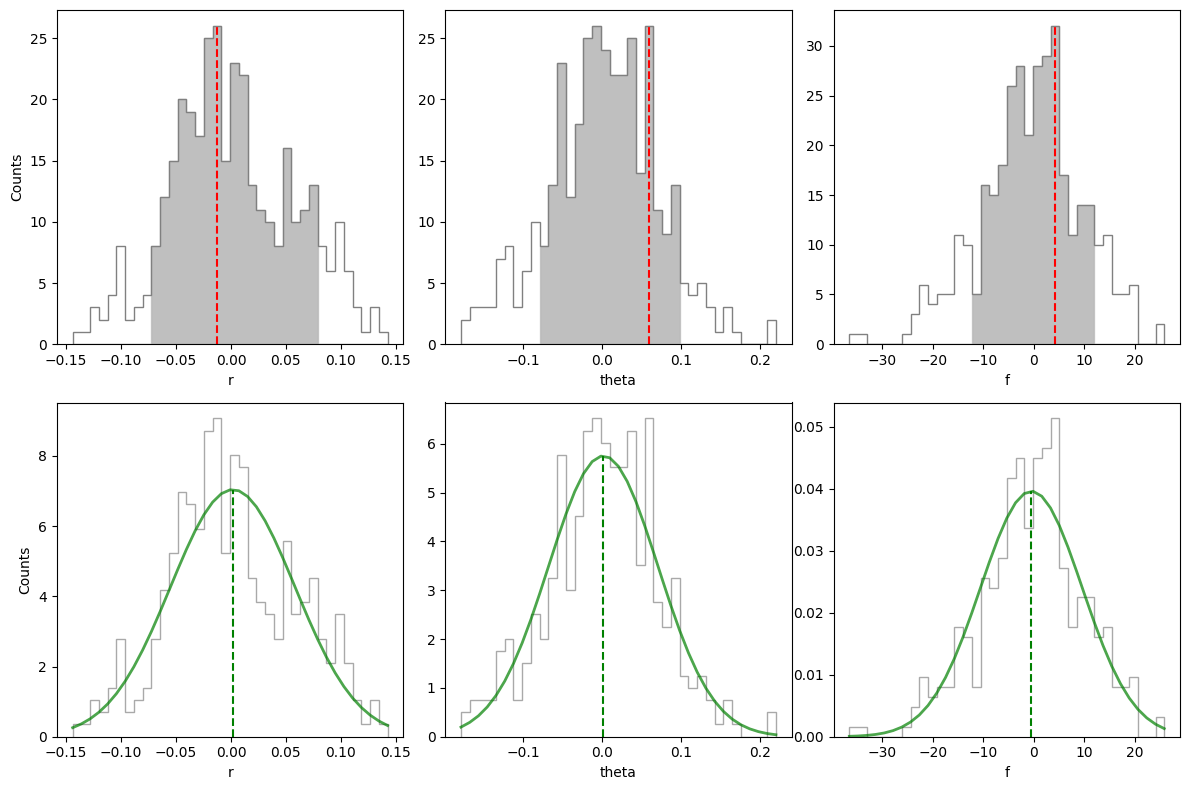

In [49]:
from vip_hci.fm import speckle_noise_uncertainty
algo_options={'ncomp':opt_npc_ann, 'annulus_width':4*fwhm_naco, 'imlib':imlib_rot, 
              'interpolation':interpolation}
speckle_res = speckle_noise_uncertainty(cubefc, pl_par, np.linspace(0,359,360), angs, pca_annulus, 
                                        psfn, fwhm_naco, aperture_radius=2, fmerit='sum', 
                                        algo_options=algo_options, transmission=None, mu_sigma=None, 
                                        wedge=None, weights=None, force_rPA=False, nproc=None, 
                                        simplex_options=None, bins=None, save=False, output=None, 
                                        verbose=True, full_output=True, plot=True)

Again, if you wish to write the result (to avoid having to run the previous box again), just set `write=True`. This will pickle the result:

In [50]:
write=False

if write:
    output = {'speckle_res':speckle_res}
    with open('../datasets/my_speckle_residuals_results', 'wb') as fileSave:
        pickle.dump(output, fileSave)

Load pickled results from disk:

In [51]:
with open('../datasets/speckle_residuals_results','rb') as fi:
    myPickler = pickle.Unpickler(fi)
    sp_unc_result = myPickler.load()

print(sp_unc_result.keys())

speckle_res = sp_unc_result['speckle_res']
sp_unc, mean_dev, p_simplex, offset, chi2, nit, success = speckle_res

dict_keys(['speckle_res'])


The speckle uncertainty associated to each parameter is contained in `sp_unc` which corresponds to the 1$\sigma$ width of a Gaussian distribution fitted to the `offset` distribution (i.e. the differences with respect to injected ground truths):

In [52]:
sp_unc

array([ 0.05350939,  0.07376633, 10.64773837])

For comparison, the uncertainties found by the MCMC procedure (which also include Poisson noise) were:

In [53]:
sigma

array([ 0.13676103,  0.15744912, 21.66963444])

### 5.3.6. Final uncertainties

The final uncertainties on the planet parameters should include both **statistical** and **systematic** uncertainties. 
The former include both the *photon noise* and *residual speckle noise* uncertainties discussed above. 
The latter include both the uncertainty on the *star location* (which may be non-negligible when using a coronagraph) and *instrumental calibration errors*, including:

- the uncertainty on the plate scale (for $r$, when converting to angular separation) - note that it is proportional to the radial separation itself;
- the uncertainty on the PA of true north (for $\theta$).

The uncertainty on the star location is of the order of 0.3px in individual NACO+AGPM images (this is the typical precision by manual recentering during the observation). Given the shift plots in `Tutorial 2`, it appears the autocorrelation timescale is of the order of ~5 frames. Therefore, considering that there are 61 frames in the datacube, the uncertainty on the star location in the final combined image must be roughly:

In [54]:
cen_unc_indiv = 0.3 #px
cen_unc = cen_unc_indiv/np.sqrt(61/5) #px
cen_unc

0.08588975014708022

The latter can be translated into an uncertainty on $\theta$ by division by the radial separation of the companion. The stellar centering uncertainties on each planet parameter can thus be expressed as:

In [55]:
star_unc = np.array([cen_unc*pxscale_naco, 
                     np.rad2deg(cen_unc/val_max['r']), 
                     0]) # uncertainty on each of the 3 parameters due to stellar centering

where the multiplication by `pxscale_naco` has converted the radial separation in arcsec.

For the instrumental calibration errors, we adopt the values quoted in Absil et al. (2013). Note that the uncertainty related to the plate scale is directly proportional to the radial separation of the companion.

In [56]:
dr_unc = 0.00004 # plate scale uncertainty in arcsec per px
tn_unc = 0.09    # uncertainty on true north in deg
syst_unc = np.array([val_max['r']*dr_unc, 
                     tn_unc, 
                     0])

The final uncertainties are then the different sources of uncertainty added quadratically - after conversion of the radial separation to arcsec:

In [57]:
sigma[0] *= pxscale_naco
sp_unc[0] *= pxscale_naco

if mu_sigma:
    final_unc = np.sqrt(np.power(sigma,2) + np.power(star_unc,2) + np.power(syst_unc,2))
else:
    final_unc = np.sqrt(np.power(sigma,2) + np.power(sp_unc,2) + np.power(star_unc,2) + np.power(syst_unc,2))

In [58]:
msg = "The final estimates on the radial separation, PA and flux of the companion, including uncertainties, are: \n"
msg+= "r = {:.2f}+-{:.2f} mas (GT: {:.2f} mas), \n"
msg+= "PA = {:.2f}+-{:.2f} deg (GT: {:.2f} deg) \n"
msg+= "f = {:.2f}+-{:.2f} ADUs (GT: {:.2f} ADUs)"
print(msg.format(val_max['r']*pxscale_naco*1000, final_unc[0]*1000, rad_fc*pxscale_naco*1000,
                 val_max['theta'], final_unc[1], theta_fc,
                 val_max['f'], final_unc[2], flux_fc))

The final estimates on the radial separation, PA and flux of the companion, including uncertainties, are: 
r = 831.33+-4.78 mas (GT: 829.29 mas), 
PA = 239.92+-0.25 deg (GT: 240.00 deg) 
f = 390.77+-24.14 ADUs (GT: 400.00 ADUs)


Let's consider the Gaussian fit instead:

In [59]:
msg = "Considering a Gaussian fit to the posterior distributions, the final estimates on the radial separation, PA and flux of the companion, including uncertainties, are: \n"
msg+= "r = {:.2f}+-{:.2f} mas (GT: {:.2f} mas), \n"
msg+= "PA = {:.2f}+-{:.2f} deg (GT: {:.2f} deg) \n"
msg+= "f = {:.2f}+-{:.2f} ADUs (GT: {:.2f} ADUs)"
print(msg.format(mu[0]*pxscale_naco*1000, final_unc[0]*1000, rad_fc*pxscale_naco*1000,
                 mu[1], final_unc[1], theta_fc,
                 mu[2], final_unc[2], flux_fc))

Considering a Gaussian fit to the posterior distributions, the final estimates on the radial separation, PA and flux of the companion, including uncertainties, are: 
r = 830.00+-4.78 mas (GT: 829.29 mas), 
PA = 239.95+-0.25 deg (GT: 240.00 deg) 
f = 394.13+-24.14 ADUs (GT: 400.00 ADUs)
